In [1]:
import datetime

from skdecide.hub.domain.flight_planning.domain import FlightPlanningDomain, WeatherDate

from skdecide.hub.solver.astar import Astar

import time
from copy import deepcopy
import networkx as nx
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from cartopy import crs as ccrs
from cartopy.feature import BORDERS, LAND, OCEAN
from matplotlib.figure import Figure
from openap import aero
from openap.extra.aero import ft, nm
from pygeodesy.ellipsoidalVincenty import LatLon

# reload
%load_ext autoreload
%autoreload 2

In [2]:
def plot_full(domain) -> Figure:
    network = domain.network

    index_first = 0
    index_last = list(network.nodes)[-1]

    node_first = network.nodes[index_first]
    node_last = network.nodes[index_last]

    fig = plt.figure(figsize=(15, 10))

    # define the grid layout
    gs = gridspec.GridSpec(1, 2)

    # add subplots for the line plots
    ax1 = fig.add_subplot(gs[0])

    # values
    lat1 = node_first["lat"]
    lon1 = node_first["lon"]
    lat2 = node_last["lat"]
    lon2 = node_last["lon"]


    # plot the altitude
    for node in network.nodes:
        ax1.scatter(
            network.nodes[node]["dist_destination"] / nm,
            network.nodes[node]["height"] / ft,
            color='k',
            s=0.5
        )

    # # plot edges in altitude
    # for edge in network.edges:
    #     ax1.plot(
    #         [
    #             network.nodes[edge[0]]["dist_destination"] / nm,
    #             network.nodes[edge[1]]["dist_destination"] / nm
    #         ],
    #         [
    #             network.nodes[edge[0]]["height"] / ft,
    #             network.nodes[edge[1]]["height"] / ft
    #         ],
    #         color='k',
    #         lw=0.5
    #     )

    ax1.set_xlabel("Distance to destination (nm)")
    ax1.set_ylabel("Zp (ft)")
    ax1.set_title("Altitude profile")

    # plot the trajectory
    latmin, latmax = min(lat1, lat2), max(lat1, lat2)
    lonmin, lonmax = min(lon1, lon2), max(lon1, lon2)

    ax3 = fig.add_subplot(
        gs[1], 
        projection=ccrs.PlateCarree()
    )

    ax3.set_extent(
        [
            lonmin - 3, 
            lonmax + 3, 
            latmin - 2, 
            latmax + 2
        ]
    )

    # ax3.set_extent(
    #     [
    #         lon1 - 2, 
    #         lon1 + 2, 
    #         lat1 - 0.5, 
    #         lat1 + 1.5
    #     ]
    # )
    
    ax3.add_feature(BORDERS, lw=0.5, color="gray")
    ax3.gridlines(draw_labels=True, color="gray", alpha=0.5, ls="--")
    ax3.coastlines(resolution="50m", lw=0.5, color="gray")

    for node in network.nodes:
        ax3.scatter(
            network.nodes[node]["lon"],
            network.nodes[node]["lat"],
            transform=ccrs.Geodetic(),
            color='blue',
            s=1
        )

        

    # plot the edges
    for edge in network.edges:
        # print(f"{edge[0]} -> {edge[1]}")
        ax3.plot(
            [network.nodes[edge[0]]["lon"], network.nodes[edge[1]]["lon"]],
            [network.nodes[edge[0]]["lat"], network.nodes[edge[1]]["lat"]],
            transform=ccrs.Geodetic(),
            color='black',
            lw=0.5
        )



    plt.tight_layout()

    plt.show()

In [3]:
# we set a date valid for 4 months to avoid downloading weather data at each daily run.
today = datetime.date.today()
month = ((today.month) - 1) // 4 * 4 + 1  # will result in january, may, or september
year = today.year
day = 1

weather_date = WeatherDate(day=day, month=month, year=year)
print(weather_date)

[01 05 2024, forecast : nowcast]


In [4]:
heuristic = "lazy_fuel"
cost_function = "fuel"
origin = "LFBO"
destination = "LFPG"
aircraft = "A320"

In [8]:
domain_factory = lambda: FlightPlanningDomain(
    origin,
    destination,
    aircraft,
    starting_time=3_600 * 12,
    weather_date=weather_date,
    heuristic_name=heuristic,
    perf_model_name="PS",  # a/c performance model
    objective=cost_function,
    fuel_loop=False,
    # take_off_weight=70_000,
    
    climb_profile={
        "below_10k_ft": 250, 
        "from_10k_to_crossover": 300, 
        "above_crossover": 0.8},

    cruise_profile={"above_crossover": 0.8},

    descent_profile={
        "below_10k_ft": 300, 
        "from_10k_to_crossover": 250, 
        "above_crossover": 0.8},

    rate_of_climb_descent = {
        "climb": 1_500.0, 
        "descent": 2_000.0},

    graph_width="xlarge",

    n_branches = 21,

    steps = {
        "n_steps_climb": 15,
        "n_steps_cruise": 15,
        "n_steps_cruise_climb": 10,
        "n_steps_descent": 15,
    })

domain = domain_factory()

Poll-Schumann model
lat_start: 43.64411, lon_start: 1.34593; lat_end: 48.99566, lon_end: 2.55216
alt_crossover: 24989.315691607037


/opt/homebrew/anaconda3/envs/test_dev_skdecide311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


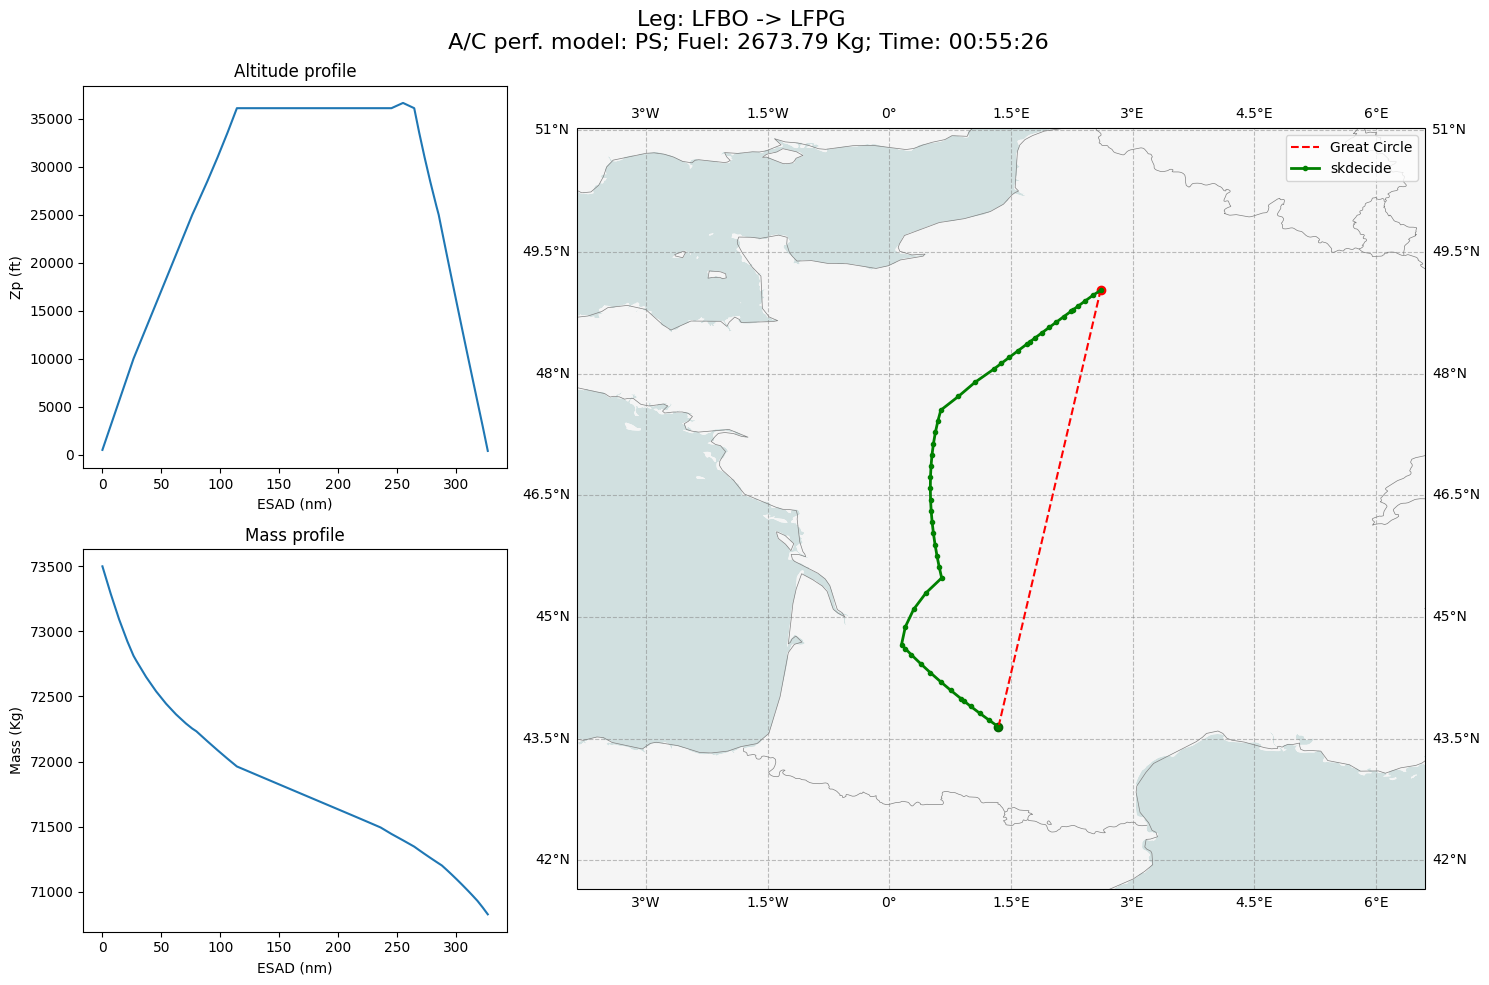

Goal reached after 50 steps!


In [9]:
with Astar(
    heuristic=lambda d, s: d.heuristic(s), domain_factory=domain_factory, parallel=False
) as solver:
    domain.solve_with(solver=solver, domain_factory=domain_factory)

    domain.custom_rollout(solver=solver, make_img=True)

/opt/homebrew/anaconda3/envs/test_dev_skdecide311/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


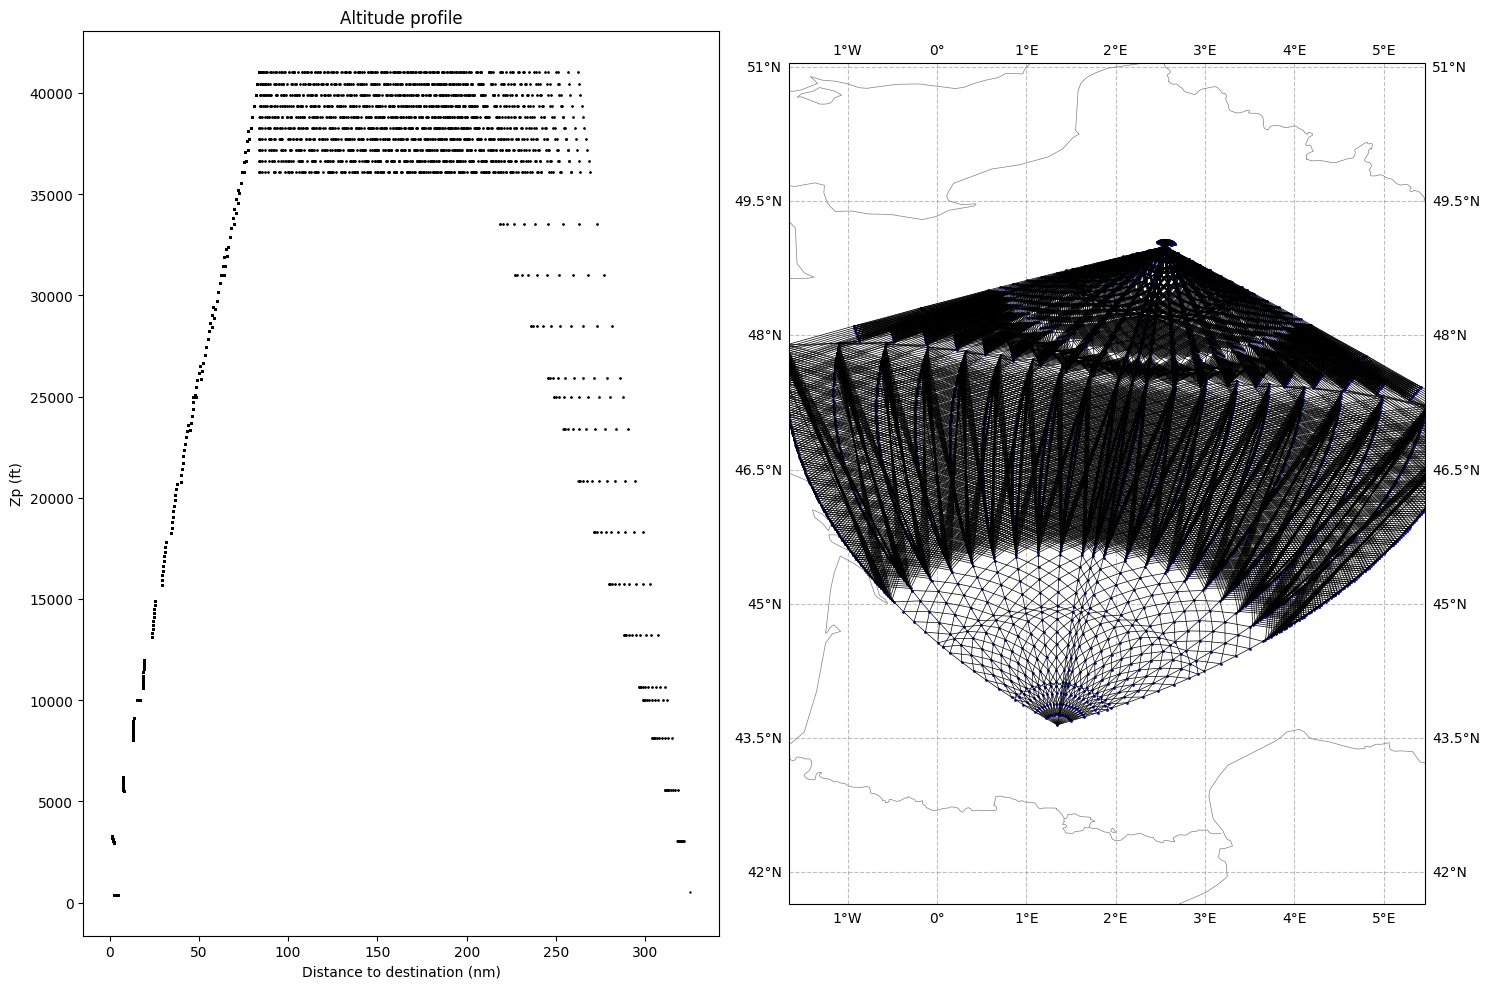

In [10]:
plot_full(domain)